## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5]
redice_lr_patient = [4, 8]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 4
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 4s 90us/step - loss: 1.5483 - accuracy: 0.4578 - val_loss: 1.6293 - val_accuracy: 0.4309
Epoch 11/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5267 - accuracy: 0.4661 - val_loss: 1.6195 - val_accuracy: 0.4348
Epoch 12/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5088 - accuracy: 0.4724 - val_loss: 1.6096 - val_accuracy: 0.4368
Epoch 13/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.4904 - accuracy: 0.4782 - val_loss: 1.5976 - val_accuracy: 0.4409
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.4732 - accuracy: 0.4846 - val_loss: 1.5956 - val_accuracy: 0.4407
Epoch 15/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4577 - accuracy: 0.4909 - val_loss: 1.5853 - val_accuracy: 0.4481
Epoch 16/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.4414 - accuracy: 0.4966 - val_loss: 1.5750

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.4957 - accuracy: 0.2049 - val_loss: 2.1827 - val_accuracy: 0.1897
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.9939 - accuracy: 0.3170 - val_loss: 2.0559 - val_accuracy: 0.2694
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.8427 - accuracy: 0.3601 - val_loss: 1.9429 - val_accuracy: 0.3103
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.7623 - accuracy: 0.3856 - val_loss: 1.8457 - val_accuracy: 0.3493
Epoch 5/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.7064 - accuracy: 0.4039 - val_loss: 1.7749 - val_accuracy: 0.3699
Epoch 6/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.6649 - accuracy: 0.4199 - val_loss: 1.7197 - val_accuracy: 0.3907
Epoch 7/25
50000/50000 [==============================] - 4s 89us/s

Epoch 20/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.5739 - accuracy: 0.8242 - val_loss: 1.4008 - val_accuracy: 0.5399

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 21/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.5543 - accuracy: 0.8321 - val_loss: 1.3918 - val_accuracy: 0.5445
Epoch 22/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.5490 - accuracy: 0.8363 - val_loss: 1.3970 - val_accuracy: 0.5438
Epoch 23/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.5457 - accuracy: 0.8368 - val_loss: 1.3996 - val_accuracy: 0.5421
Epoch 24/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.5430 - accuracy: 0.8370 - val_loss: 1.4039 - val_accuracy: 0.5443

Epoch 00024: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.5359 - accuracy:

Epoch 4/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.7544 - accuracy: 0.3919 - val_loss: 1.8733 - val_accuracy: 0.3391
Epoch 5/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.7095 - accuracy: 0.4046 - val_loss: 1.7963 - val_accuracy: 0.3642
Epoch 6/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.6756 - accuracy: 0.4163 - val_loss: 1.7459 - val_accuracy: 0.3815
Epoch 7/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.6483 - accuracy: 0.4259 - val_loss: 1.7178 - val_accuracy: 0.3932
Epoch 8/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.6248 - accuracy: 0.4339 - val_loss: 1.6970 - val_accuracy: 0.4012
Epoch 9/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.6034 - accuracy: 0.4401 - val_loss: 1.6831 - val_accuracy: 0.4065
Epoch 10/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5843 - accuracy: 0.4476 - val_loss

50000/50000 [==============================] - 5s 96us/step - loss: 1.4164 - accuracy: 0.5089 - val_loss: 1.5896 - val_accuracy: 0.4409
Epoch 25/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.4085 - accuracy: 0.5110 - val_loss: 1.5852 - val_accuracy: 0.4434
Numbers of exp: 8, reduce_factor: 0.30, reduce_patient: 4
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______________________________________________

50000/50000 [==============================] - 5s 90us/step - loss: 1.5958 - accuracy: 0.4444 - val_loss: 1.6662 - val_accuracy: 0.4192
Epoch 8/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5593 - accuracy: 0.4579 - val_loss: 1.6385 - val_accuracy: 0.4302
Epoch 9/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5277 - accuracy: 0.4669 - val_loss: 1.6187 - val_accuracy: 0.4324
Epoch 10/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4983 - accuracy: 0.4789 - val_loss: 1.6052 - val_accuracy: 0.4435
Epoch 11/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4731 - accuracy: 0.4872 - val_loss: 1.5959 - val_accuracy: 0.4450
Epoch 12/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4484 - accuracy: 0.4959 - val_loss: 1.5830 - val_accuracy: 0.4490
Epoch 13/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.4261 - accuracy: 0.5049 - val_loss: 1.5834 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.3558 - accuracy: 0.2227 - val_loss: 2.1831 - val_accuracy: 0.1917
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.9723 - accuracy: 0.3244 - val_loss: 2.0768 - val_accuracy: 0.2488
Epoch 3/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.8304 - accuracy: 0.3652 - val_loss: 1.9508 - val_accuracy: 0.3123
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.7430 - accuracy: 0.3924 - val_loss: 1.8338 - val_accuracy: 0.3613
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.6785 - accuracy: 0.4132 - val_loss: 1.7625 - val_accuracy: 0.3794
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.6295 - accuracy: 0.4284 - val_loss: 1.7160 - val_accuracy: 0.3918
Epoch 7/25
50000/50000 [==============================] - 5s 94us/st

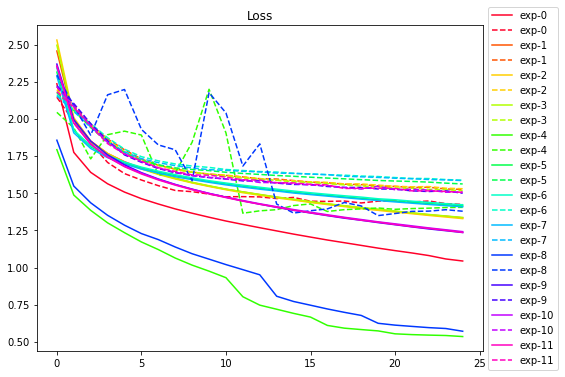

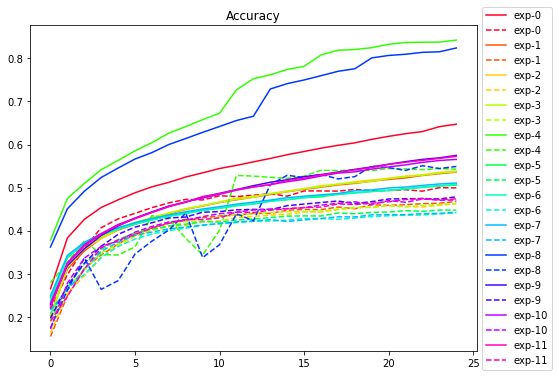

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()